# **AI-Driven Quality Control in Metal Casting Manufacturing**

## **Introduction**

In the manufacturing industry, quality control is a key process that affects a company's reputation and reliability. Traditional methods of quality inspection, especially in metal casting, often depend on manual visual checks. These checks can be slow, tiring, and prone to mistakes because they rely on humans. With the rise of Artificial Intelligence (AI) and Deep Learning, particularly Convolutional Neural Networks (CNNs), there is a great opportunity to automate and improve the accuracy of these inspections. This project looks at how AI can be used to improve the quality control process in metal parts manufacturing, with a focus on submersible pump impellers.

## **Problem Definition**

The main problem in manufacturing metal casting products, like submersible pump impellers, is that the current manual inspection process is inefficient. It takes a lot of time, requires a lot of work, and can be inconsistent because of human errors. Defects like blow holes, pinholes, burrs, and shrinkage can cause significant financial losses if not detected correctly and on time. The goal of this project is to create and use a Deep Learning model with CNNs to automate the defect detection process, making it more accurate and efficient.

## **Objectives**

The main objectives of this project are:

1. **Model Development:** Develop a reliable CNN model that can accurately classify metal casting products as "Defective" or "Non-Defective" using a dataset of 7,348 gray-scale images of submersible pump impellers.

2. **Accuracy Improvement:** Achieve a minimum classification accuracy of 95% in identifying defective and non-defective metal casting products.

3. **Time Efficiency:** Reduce the time needed for quality inspections by at least 50%, which will help increase production efficiency.

4. **Cost Reduction:** Show measurable cost savings by reducing the financial impact of undetected defects and minimizing the need for rework or rejected orders.

5. **Scalability and Transfer Learning:** Explore the use of transfer learning to improve model performance and make sure that the solution can be scaled to other similar use cases in the manufacturing industry.


## **Submersible Pump Impeller Aplication:**

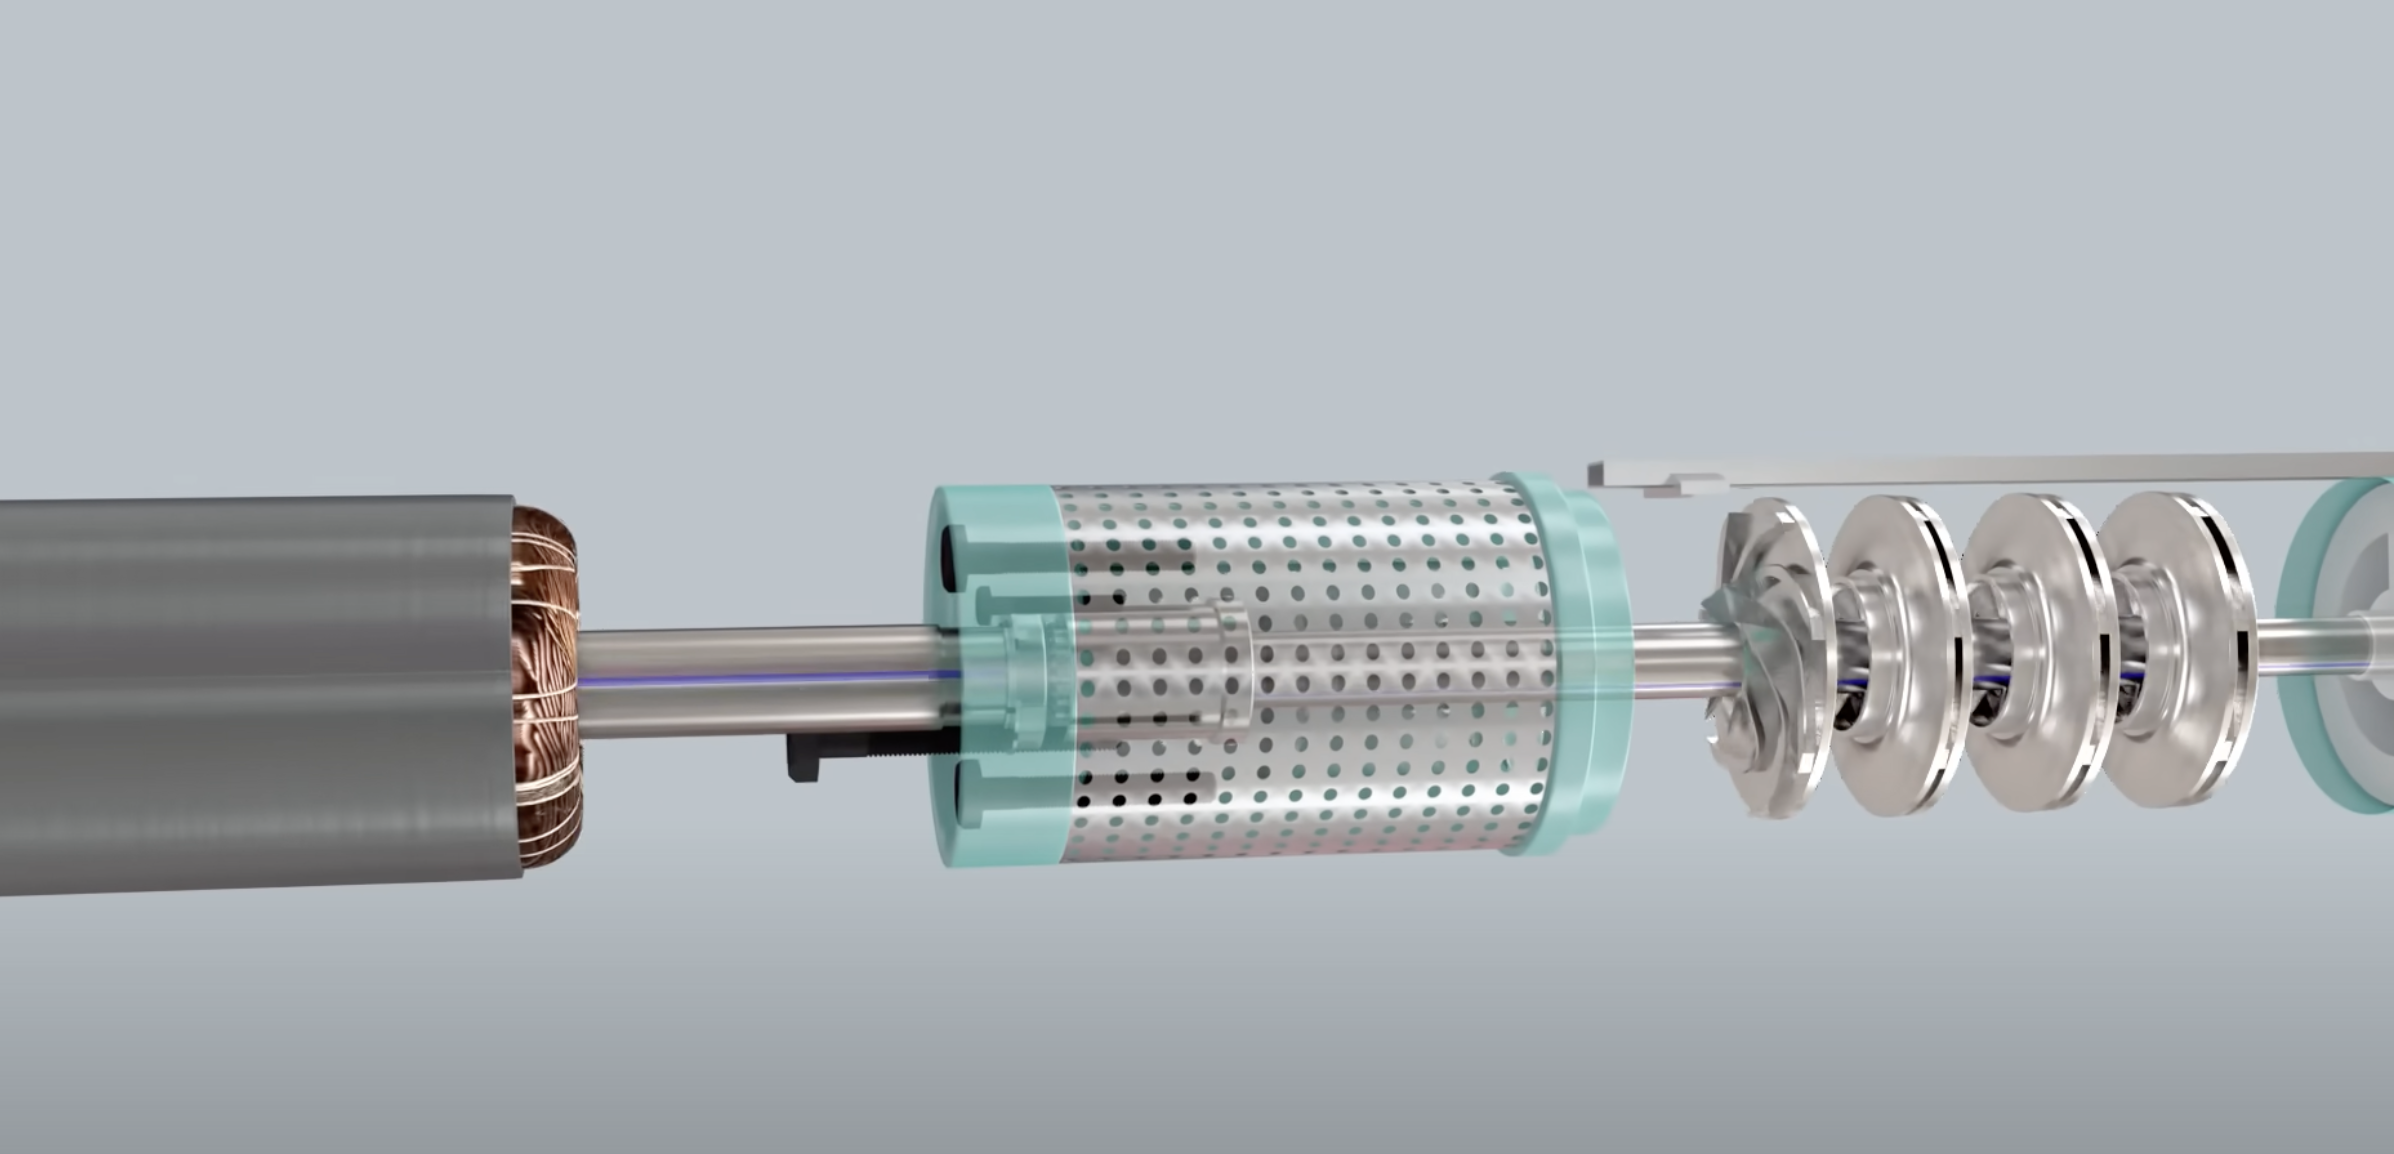

### Defects Classification
During this study Good parts will be referred as "OK",
While Defective Parts will be marked as "DEF" (Defective)

# "OK" Part :
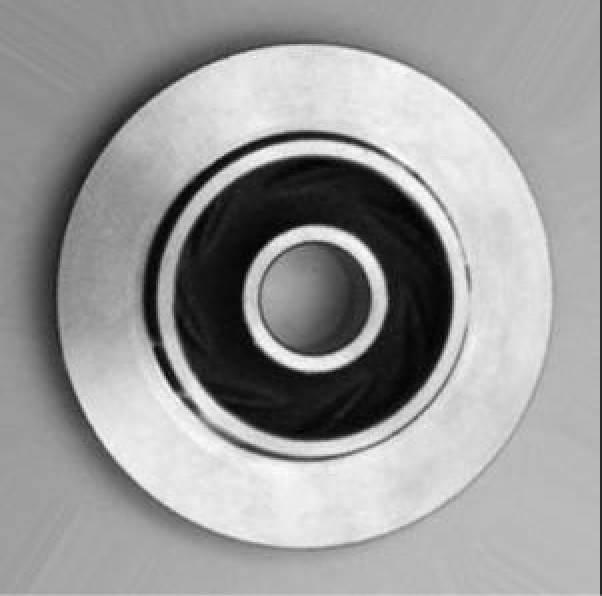 
# "DEF" Part (Defective):
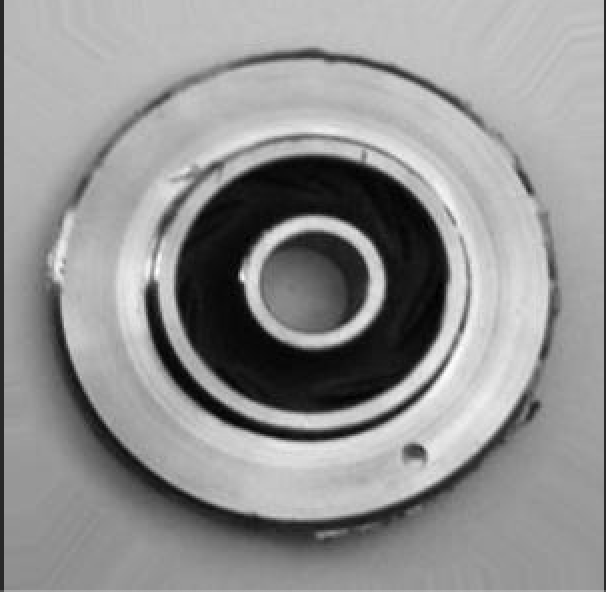

In [63]:
#!pip install tensorflow

In [64]:
#Import all the necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from skimage.measure import shannon_entropy
import random
from PIL import Image


In [65]:
# Define the paths
train_dir = '/Users/javie/Datascience/Springboard/Capstones/Capstone3/Pictures/casting_data/train'
test_dir = '/Users/javie/Datascience/Springboard/Capstones/Capstone3/Pictures/casting_data/test'

# Visualization of Defective and OK Parts pulling data from the Pictures

Let’s take a look at the structure of your dataset and understand the distribution of images in each category (Defective vs OK).

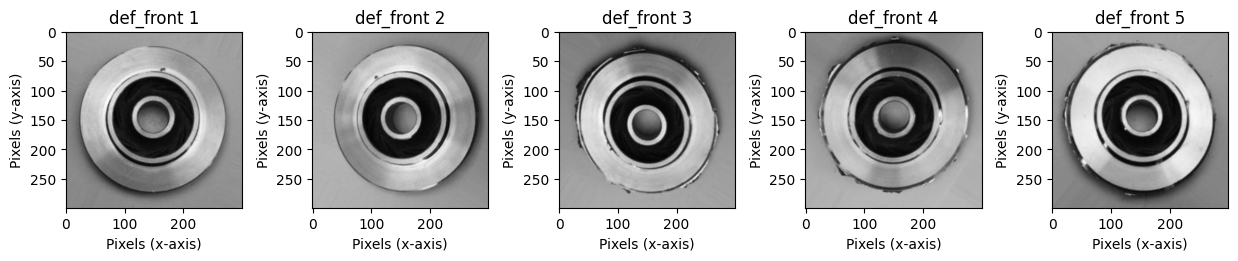

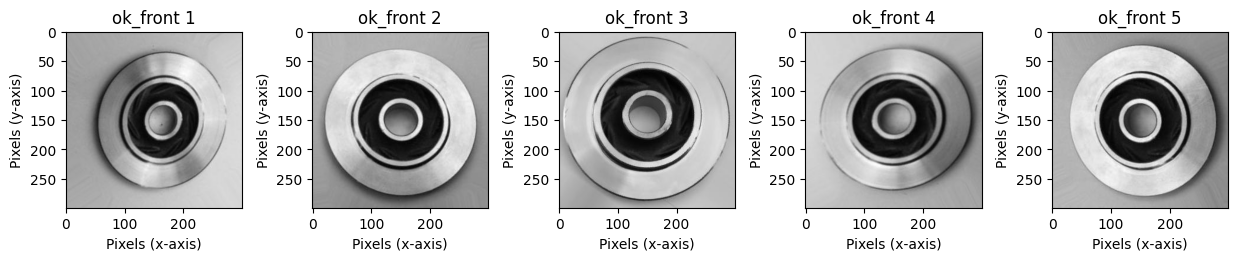

In [66]:

def plot_images(directory, category, num_images=5):
    folder = os.path.join(directory, category)
    images = os.listdir(folder)[:num_images]

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(folder, img_name)
        img = plt.imread(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img, cmap='gray')
        plt.xlabel('Pixels (x-axis)')
        plt.ylabel('Pixels (y-axis)')
        plt.title(f"{category} {i+1}")

    plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust space between plots
    plt.show()

# Plot images from training set
plot_images(train_dir, 'def_front')
plot_images(train_dir, 'ok_front')

In [67]:
# See the shape of OK Image
img_path = os.path.join(train_dir, 'ok_front', 'cast_ok_0_1.jpeg')
img = plt.imread(img_path)
print(f"Image shape: {img.shape}")

# See the shape of a random Defective Image
img_path = os.path.join(train_dir, 'def_front', 'cast_def_0_0.jpeg')
img = plt.imread(img_path)
print(f"Image shape: {img.shape}")


Image shape: (300, 300, 3)
Image shape: (300, 300, 3)


The third number represents the number of color channels in the image.

In [68]:
# Count the number of images in each category
def count_images(directory):
    def_count = len(os.listdir(os.path.join(directory, 'def_front')))
    ok_count = len(os.listdir(os.path.join(directory, 'ok_front')))
    return def_count, ok_count

train_def, train_ok = count_images(train_dir)
test_def, test_ok = count_images(test_dir)

print(f"Training set: {train_def} defective, {train_ok} OK")
print(f"Test set: {test_def} defective, {test_ok} OK")

Training set: 3758 defective, 2875 OK
Test set: 453 defective, 262 OK


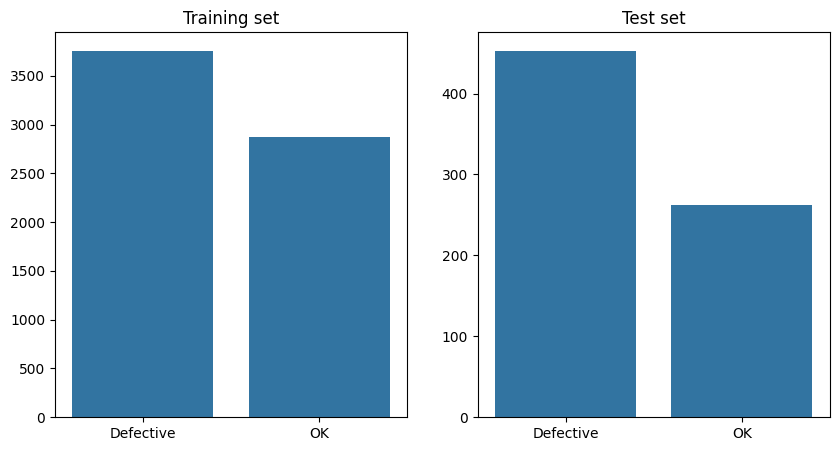

In [69]:
# Plot the number of images in each category
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(x=['Defective', 'OK'], y=[train_def, train_ok], ax=ax[0])
sns.barplot(x=['Defective', 'OK'], y=[test_def, test_ok], ax=ax[1])
ax[0].set_title('Training set')
ax[1].set_title('Test set')
plt.show()


# Data Augmentation

Lets increase the number of OK Pictures using Data Augmentation Techniques.

Augmentation

In [70]:
# Directory of original images
train_dir = '/Users/javie/Datascience/Springboard/Capstones/Capstone3/Pictures/casting_data/train'
ok_category = 'ok_front'

# Number of OK images to generate to balance the classes
num_augments = 900

# Initialize the ImageDataGenerator with augmentation settings
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to augment images in the OK category
def augment_ok_images(category, num_augments):
    category_dir = os.path.join(train_dir, category)
    augmented_dir = os.path.join(category_dir + '_augmented')

    # Create a directory to save the augmented images
    if not os.path.exists(augmented_dir):
        os.makedirs(augmented_dir)

    # Load the images
    image_list = os.listdir(category_dir)

    # Calculate how many images should be generated from each original image
    num_images = len(image_list)
    augment_per_image = num_augments // num_images

    total_generated = 0  # Counter for generated images

    for image_name in image_list:
        image_path = os.path.join(category_dir, image_name)
        image = plt.imread(image_path)
        image = np.expand_dims(image, axis=0)

        # Generate the specified number of augmented images per original image
        i = 0
        for batch in datagen.flow(image, batch_size=1, save_to_dir=augmented_dir, save_prefix='aug', save_format='png'):
            i += 1
            total_generated += 1
            if i >= augment_per_image or total_generated >= num_augments:  # Stop when the required number is reached
                break
        if total_generated >= num_augments:
            break

    print(f"{total_generated} augmented images generated for {category}. Saved in {augmented_dir}.")

# Apply the augmentation only to the OK category
augment_ok_images(ok_category, num_augments)

900 augmented images generated for ok_front. Saved in /Users/javie/Datascience/Springboard/Capstones/Capstone3/Pictures/casting_data/train/ok_front_augmented.


Merge original OK pictures + Augmented OK pictures 

In [71]:
# Training directory
train_dir = '/Users/javie/Datascience/Springboard/Capstones/Capstone3/Pictures/casting_data/train'

# Directories of interest
ok_dir = os.path.join(train_dir, 'ok_front')
ok_augmented_dir = os.path.join(train_dir, 'ok_front_augmented')
ok_merged_dir = os.path.join(train_dir, 'OK_Merged')

# Create the OK_Merged directory if it doesn't exist
os.makedirs(ok_merged_dir, exist_ok=True)

# Function to copy images from one directory to another
def copy_images_to_merged(source_dir, target_dir):
    for img_name in os.listdir(source_dir):
        src_path = os.path.join(source_dir, img_name)
        if os.path.isfile(src_path):  # Ensure it's a file
            dest_path = os.path.join(target_dir, img_name)
            shutil.copy(src_path, dest_path)  # Use copy instead of move

# Copy original images from ok_front to OK_Merged
copy_images_to_merged(ok_dir, ok_merged_dir)

# Copy augmented images from ok_front_augmented to OK_Merged
copy_images_to_merged(ok_augmented_dir, ok_merged_dir)

print("OK_Merged directory created with original and augmented OK images.")

OK_Merged directory created with original and augmented OK images.


In [72]:
# Directories to be removed from the training set and stored later in a "backup folder"
ok_dir = os.path.join(train_dir, 'ok_front')
ok_augmented_dir = os.path.join(train_dir, 'ok_front_augmented')

# Directory for backup
backup_dir = os.path.join(train_dir, 'BACKUP')
os.makedirs(backup_dir, exist_ok=True)

# Function to move a directory to another destination
def move_directory_to_backup(source_dir, backup_dir):
    dest_dir = os.path.join(backup_dir, os.path.basename(source_dir))
    shutil.move(source_dir, dest_dir)
    print(f"Directory {source_dir} moved to {dest_dir}")

# Move the ok_front and ok_front_augmented folders to the BACKUP folder
move_directory_to_backup(ok_dir, backup_dir)
move_directory_to_backup(ok_augmented_dir, backup_dir)

print("Directories moved to BACKUP successfully.")

Directory /Users/javie/Datascience/Springboard/Capstones/Capstone3/Pictures/casting_data/train/ok_front moved to /Users/javie/Datascience/Springboard/Capstones/Capstone3/Pictures/casting_data/train/BACKUP/ok_front
Directory /Users/javie/Datascience/Springboard/Capstones/Capstone3/Pictures/casting_data/train/ok_front_augmented moved to /Users/javie/Datascience/Springboard/Capstones/Capstone3/Pictures/casting_data/train/BACKUP/ok_front_augmented
Directories moved to BACKUP successfully.


In [73]:
# Function to count images in a given category
def count_total_images(category):
    category_dir = os.path.join(train_dir, category)
    total_images = len(os.listdir(category_dir))
    return total_images

# Count the images in both categories
total_ok = count_total_images('OK_Merged')
total_def = count_total_images('def_front')

print(f"Total images in OK category: {total_ok}")
print(f"Total images in Defective category: {total_def}")

Total images in OK category: 3728
Total images in Defective category: 3758


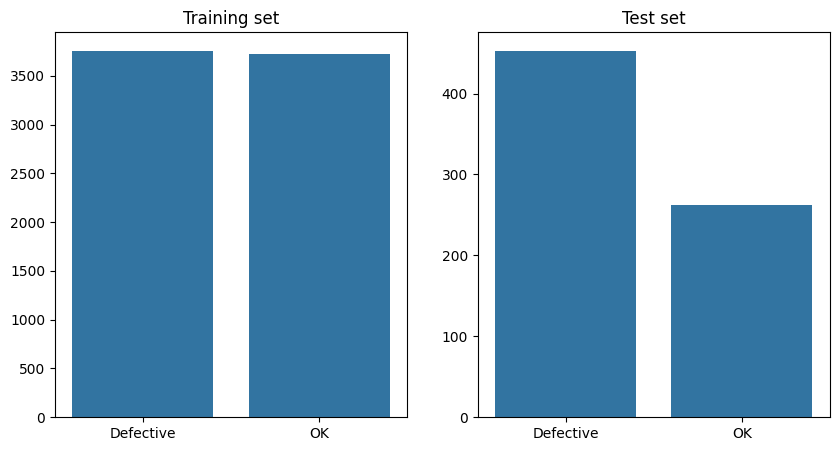

In [74]:
# Function to count images in a given directory
def count_images(directory):
    return len(os.listdir(directory))

# Directories to be counted (Train and Test)
train_def_dir = '/Users/javie/Datascience/Springboard/Capstones/Capstone3/Pictures/casting_data/train/def_front'
train_ok_dir = '/Users/javie/Datascience/Springboard/Capstones/Capstone3/Pictures/casting_data/train/OK_Merged'
test_def_dir = '/Users/javie/Datascience/Springboard/Capstones/Capstone3/Pictures/casting_data/test/def_front'
test_ok_dir = '/Users/javie/Datascience/Springboard/Capstones/Capstone3/Pictures/casting_data/test/ok_front'

# Count the number of images in each category after merging augmented data
train_def = count_images(train_def_dir)
train_ok = count_images(train_ok_dir)
test_def = count_images(test_def_dir)
test_ok = count_images(test_ok_dir)

# Plot the number of images in each category
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(x=['Defective', 'OK'], y=[train_def, train_ok], ax=ax[0])
sns.barplot(x=['Defective', 'OK'], y=[test_def, test_ok], ax=ax[1])
ax[0].set_title('Training set')
ax[1].set_title('Test set')
plt.show()

In [86]:
# Review the images in the training set to see if they are all the same size
def check_image_size(directory):
    sizes = []
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        with Image.open(img_path) as img:
            sizes.append(img.size)

    unique_sizes = set(sizes)

    # Get only the last part of the directory path
    dir_name = os.path.basename(directory)

    print(f"Unique image sizes in /{dir_name}: {unique_sizes}")

# Check sizes for both categories
check_image_size(train_def_dir)
check_image_size(train_ok_dir)

Unique image sizes in /def_front: {(300, 300)}
Unique image sizes in /OK_Merged: {(300, 300)}


In [88]:
def get_combined_pixel_data(category, sample_size=30):
    folder = os.path.join(train_dir, category)
    images = os.listdir(folder)

    # Select a random sample of 30 images to get a pixel data intensity histogram
    sampled_images = random.sample(images, sample_size)

    # Start an array to store the value of the pixels
    combined_pixel_data = []

    for img_name in sampled_images:
        img_path = os.path.join(folder, img_name)
        img = plt.imread(img_path)
        combined_pixel_data.extend(img.ravel())

    return np.array(combined_pixel_data)

# combine the values of the 30 images in each category
def_pixel_data = get_combined_pixel_data('def_front', sample_size=30)
ok_pixel_data = get_combined_pixel_data('OK_Merged', sample_size=30)

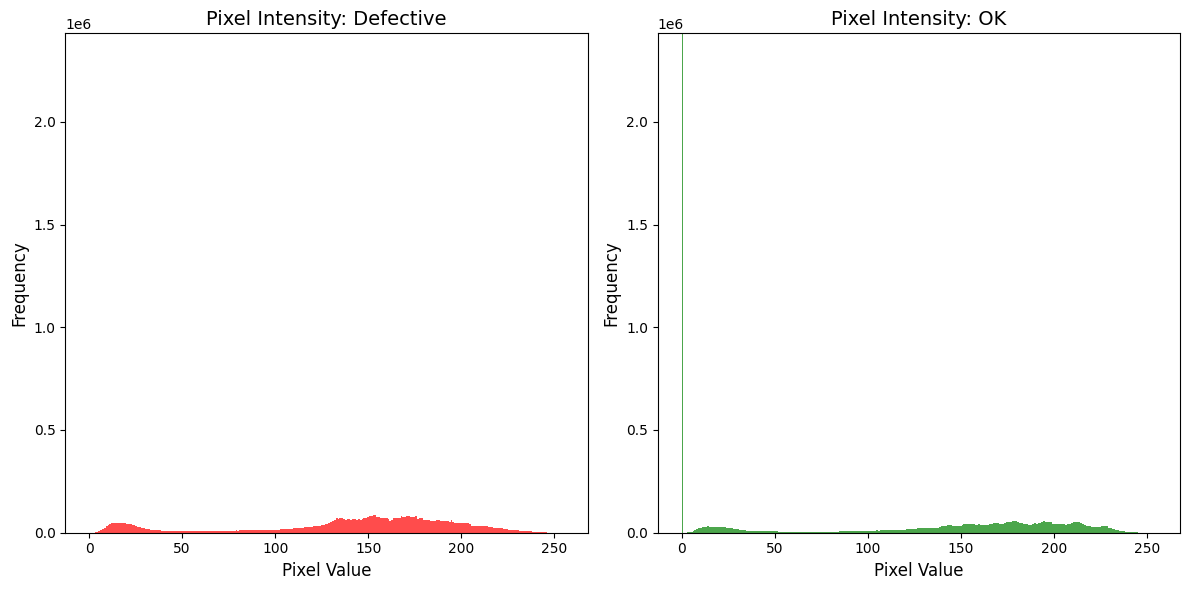

In [89]:
def plot_combined_histogram(def_data, ok_data):
    plt.figure(figsize=(12, 6))

    # Determine the maximum frequency to set the same Y scale for both histograms
    max_freq = max(max(np.histogram(def_data, bins=256)[0]), max(np.histogram(ok_data, bins=256)[0]))

    # Histogram for defective images
    plt.subplot(1, 2, 1)
    plt.hist(def_data, bins=256, color='red', alpha=0.7)
    plt.title('Pixel Intensity: Defective', fontsize=14)
    plt.xlabel('Pixel Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.ylim(0, max_freq)  # Set the Y-axis limit

    # Histogram for OK images
    plt.subplot(1, 2, 2)
    plt.hist(ok_data, bins=256, color='green', alpha=0.7)
    plt.title('Pixel Intensity: OK', fontsize=14)
    plt.xlabel('Pixel Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.ylim(0, max_freq)  # Set the Y-axis limit

    plt.tight_layout()
    plt.show()

# Generate the combined histograms
plot_combined_histogram(def_pixel_data, ok_pixel_data)

Some difference can be observed in both histograms, however this is not enough evidence to understand if the model will segregate correctly both groups. We will test later the model acuracy with the Test Pictures

Another way to see any differences in the population is to calculate the entropy of both groups. Lets see how it looks:

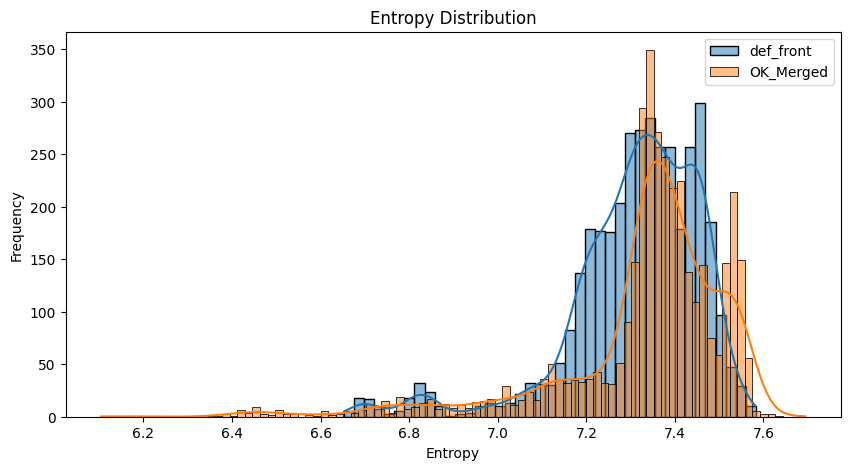

In [90]:
def calculate_entropy(image_path):
    img = plt.imread(image_path)
    return shannon_entropy(img)

def analyze_entropy(directory):
    entropies = {'def_front': [], 'OK_Merged': []}

    for category in entropies.keys():
        folder = os.path.join(directory, category)
        images = os.listdir(folder)

        for img_name in images:
            img_path = os.path.join(folder, img_name)
            entropy_value = calculate_entropy(img_path)
            entropies[category].append(entropy_value)

    plt.figure(figsize=(10, 5))
    for category, entropy_values in entropies.items():
        sns.histplot(entropy_values, kde=True, label=category)

    plt.title('Entropy Distribution')
    plt.xlabel('Entropy')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Perform entropy analysis for training dataframe
analyze_entropy(train_dir)

Again we can see some difference between both groups. Now the entropy of Defective parts seems to have a higher standard deviation

## Conclusion

In this notebook, we conducted an exploratory data analysis (EDA) and various data wrangling processes on a dataset of pump images categorized as defective (`def_front`) and non-defective (`ok_front`). Below is a summary of the key findings and steps performed:

1. **Image Visualization**:
   - We visually explored a set of images from both categories to understand the general characteristics of defective and non-defective pumps.
   - This initial visualization provided a foundational understanding of the differences between the images, which informed subsequent analyses.

2. **Image Distribution by Category**:
   - We counted and visualized the distribution of images in both categories across the training and testing sets.
   - The dataset appears to be relatively balanced between the two classes, which is beneficial for training classification models.

3. **Image Size Analysis**:
   - We verified the sizes of the images to ensure uniformity across the dataset. This step is crucial for consistent processing in later stages of the pipeline.

4. **Pixel Data Combination and Histogram Analysis**:
   - We combined pixel data from a sample of images and generated histograms to visualize the distribution of pixel intensity across both categories.
   - This analysis revealed differences in pixel intensity distribution, which could indicate unique characteristics in defective pumps.

5. **Entropy Analysis**:
   - We calculated the entropy of the images to measure the amount of information contained within them.
   - We found that non-defective images tend to have slightly higher entropy, suggesting they might contain more detail or variability compared to defective images.

## Implications

The analyses conducted provide an initial understanding of the dataset, which is essential for guiding the next phases of the project, such as training image classification models. The differences in pixel intensity suggest that these features could be useful in distinguishing between defective and non-defective pumps in a classification model.

## Next Steps

1. **Modeling**: Use the identified features from the analysis to train and evaluate classification models.
2. **Advanced Evaluation**: Consider using more advanced techniques, such as transferred learning to enhance model accuracy.